# ITAI 2373 – Midterm Project  
## NewsBot Intelligence System – BBC News Dataset

### Project Overview

In this midterm project, I build a NewsBot Intelligence System that processes and analyzes news articles using an end-to-end NLP pipeline. The system is based on the BBC News dataset from Kaggle and implements all core components from Modules 1–8:

- Text preprocessing
- TF-IDF feature extraction
- POS and syntax analysis
- Sentiment/emotion analysis
- Multi-class text classification
- Named Entity Recognition (NER)

The goal is to demonstrate how these techniques work together to support a real-world media monitoring application.


## Module 1 – Real-World NLP Application Context

**Business case & industry context**

This system is designed for a media analytics team that needs to automatically organize and monitor large volumes of online news. The organization wants to track coverage across categories such as business, politics, sports, entertainment, and technology.

**Use case**

The NewsBot Intelligence System ingests news articles, classifies them into categories, extracts key entities, and analyzes sentiment. Analysts and product managers can then use these insights to:

- Monitor trends in specific topics
- Track how often certain organizations or people are mentioned
- Identify spikes in negative or positive coverage

**Target users & value proposition**

- Target users: media analysts, communication teams, product managers, and data scientists.
- Value: reduce manual reading time, surface key stories faster, and provide structured signals (categories, entities, sentiment) for decision-making.


In [ ]:
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 54.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP & ML
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import spacy

# Sentiment
from nltk.sentiment import SentimentIntensityAnalyzer

# General settings
plt.rcParams["figure.figsize"] = (8, 5)
sns.set(style="whitegrid")

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

# Load spaCy model (you may need to run: !python -m spacy download en_core_web_sm in a separate cell)
nlp = spacy.load("en_core_web_sm")

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# Install Kaggle API
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file")
uploaded = files.upload()

# Setup kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("✅ Kaggle API setup complete!")

# Download BBC News Dataset
!kaggle competitions download -c learn-ai-bbc

# Unzip the files
!unzip learn-ai-bbc.zip

# List the files to see what we have
!ls -la

# Load the dataset
import pandas as pd
import os

# Check what files are available
print("Available files:")
for file in os.listdir('.'):
    if file.endswith('.csv'):
        print(f"  - {file}")

# Load the main dataset (adjust filename as needed)
# Common filenames: train.csv, bbc-text.csv, or similar
df = pd.read_csv('BBC News Train.csv')  # Adjust filename based on what you see
df = df.rename(columns={"Text": "content", "Category": "category"})
df = df[["content", "category"]]
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Categories: {df['category'].unique()}")  # Adjust column name as needed

Please upload your kaggle.json file


Saving kaggle.json to kaggle (5).json
✅ Kaggle API setup complete!
learn-ai-bbc.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  learn-ai-bbc.zip
replace BBC News Sample Solution.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace BBC News Test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: m
error:  invalid response [m]
replace BBC News Test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace BBC News Train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
total 6900
drwxr-xr-x 1 root root    4096 Dec 10 16:55  .
drwxr-xr-x 1 root root    4096 Dec 10 16:44  ..
drwxr-xr-x 2 root root    4096 Dec 10 16:48  bbc_data
-rw-r--r-- 1 root root   10369 Dec  2  2019 'BBC News Sample Solution.csv'
-rw-r--r-- 1 root root 1712432 Dec  2  2019 'BBC News Test.csv'
-rw-r--r-- 1 root root 3351206 Dec  2  2019 'BBC News Train.csv'
drwxr-xr-x 4 root root    4096 Nov 20 14:30  .config
-rw-r--r-- 1 root root      64 Dec 10 16:46 'kaggle (1).json'
-rw-r--r-- 1 root 

## Module 2 – Text Preprocessing Pipeline

In this section, I clean and normalize the raw news text by:
- Lowercasing
- Removing punctuation and non-alphabetic tokens
- Removing stop words
- Lemmatizing tokens

This prepares consistent input for TF-IDF and downstream models.


In [ ]:
# Data preparation template
import pandas as pd
import numpy as np

# 1. Examine your dataset
print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

# 2. Identify text and category columns
# Adjust these column names based on your dataset
text_column = 'content'  # or 'description', 'content', 'headline', etc.
category_column = 'category'  # or 'label', 'class', etc.

# 3. Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

# 4. Remove rows with missing text or categories
df_clean = df.dropna(subset=[text_column, category_column])

# 5. Check category distribution
print(f"\nCategory distribution:")
print(df_clean[category_column].value_counts())

# 6. Sample if dataset is too large (keep under 2000 for Colab)
if len(df_clean) > 2000:
    df_final = df_clean.sample(n=2000, random_state=42)
    print(f"\nSampled dataset to {len(df_final)} rows")
else:
    df_final = df_clean

# 7. Rename columns for consistency
df_final = df_final.rename(columns={
    text_column: 'content',
    category_column: 'category'
})

# 8. Save prepared dataset
df_final.to_csv('newsbot_dataset.csv', index=False)
print("\n✅ Dataset prepared and saved as 'newsbot_dataset.csv'")

Dataset Info:
Shape: (1490, 2)
Columns: ['content', 'category']

First few rows:
                                             content  category
0  worldcom ex-boss launches defence lawyers defe...  business
1  german business confidence slides german busin...  business
2  bbc poll indicates economic gloom citizens in ...  business
3  lifestyle  governs mobile choice  faster  bett...      tech
4  enron bosses in $168m payout eighteen former e...  business

Missing values:
content     0
category    0
dtype: int64

Category distribution:
category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64

✅ Dataset prepared and saved as 'newsbot_dataset.csv'


In [ ]:
import nltk
nltk.download('punkt_tab')
import re
from nltk.tokenize import word_tokenize

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(lemmas)

df["clean_text"] = df["content"].apply(preprocess_text)
df.head()


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,content,category,clean_text
0,worldcom ex-boss launches defence lawyers defe...,business,worldcom bos launch defence lawyer defending f...
1,german business confidence slides german busin...,business,german business confidence slide german busine...
2,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizen majo...
3,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster better ...
4,enron bosses in $168m payout eighteen former e...,business,enron boss payout eighteen former enron direct...


## Module 3 – TF-IDF Feature Extraction and Analysis
Here I transform the cleaned text into TF-IDF vectors and analyze category-specific important terms.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["category"], test_size=0.2, random_state=42, stratify=df["category"]
)

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape


(1192, 5000)

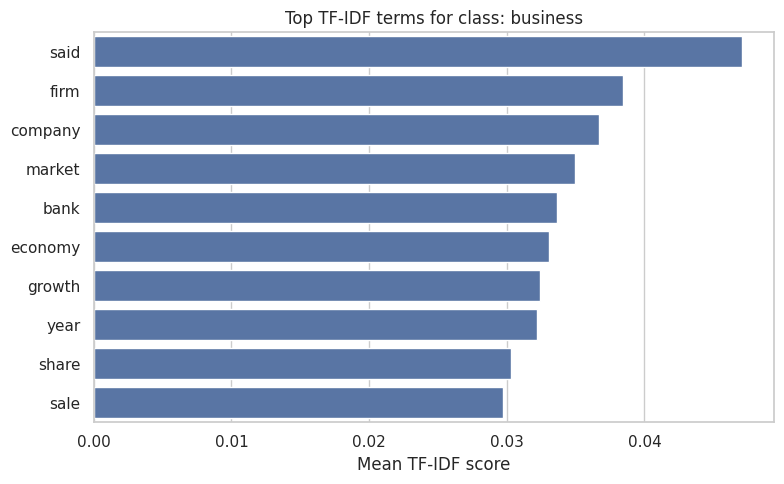

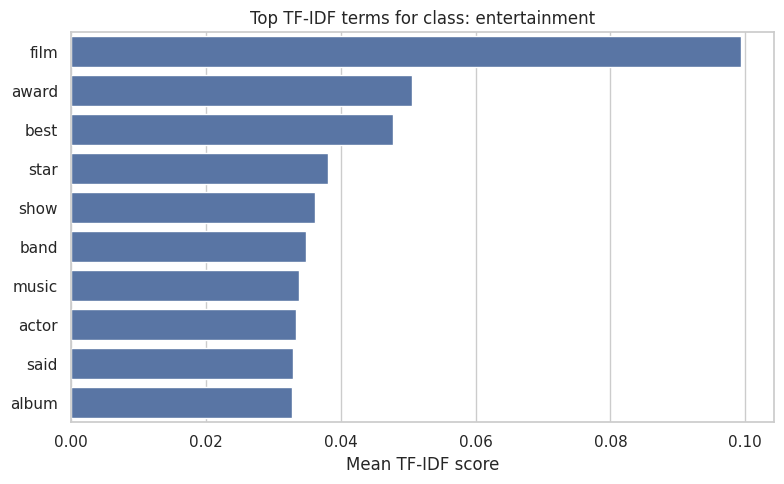

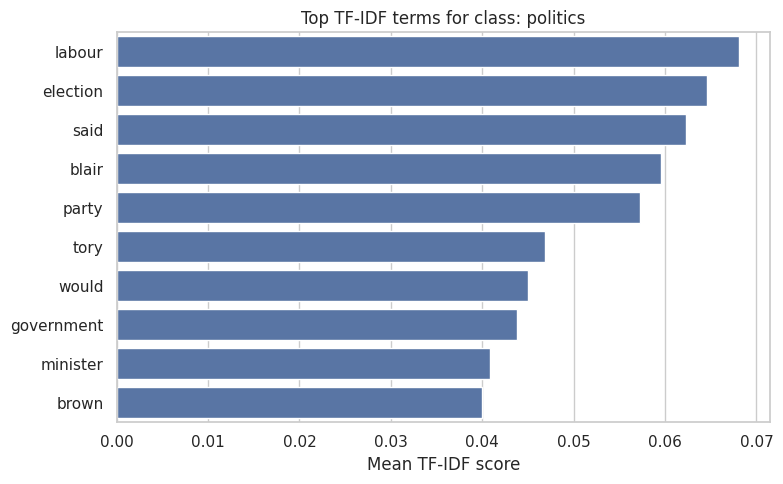

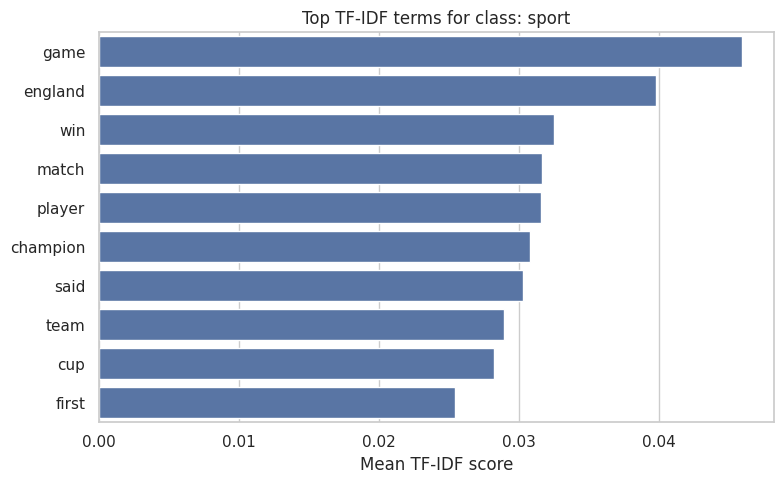

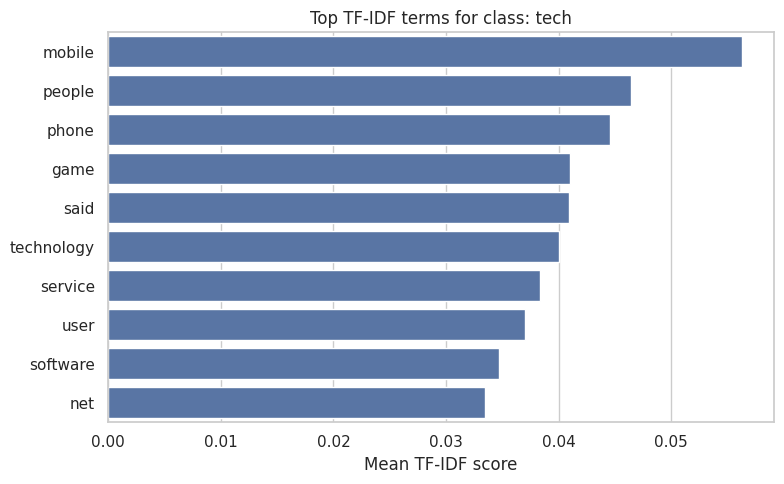

In [ ]:
def plot_top_terms_for_class(class_label, n=15):
    class_indices = np.where(y_train == class_label)[0]
    class_matrix = X_train_tfidf[class_indices]
    mean_tfidf = np.asarray(class_matrix.mean(axis=0)).ravel()
    top_idx = mean_tfidf.argsort()[::-1][:n]
    terms = np.array(tfidf.get_feature_names_out())[top_idx]
    scores = mean_tfidf[top_idx]

    plt.figure()
    sns.barplot(x=scores, y=terms)
    plt.title(f"Top TF-IDF terms for class: {class_label}")
    plt.xlabel("Mean TF-IDF score")
    plt.tight_layout()
    plt.show()

for cat in sorted(df["category"].unique()):
    plot_top_terms_for_class(cat, n=10)


## Module 4 – Part-of-Speech Pattern Analysis

Here I use spaCy to examine POS distributions across categories and compare writing style (e.g., proportion of nouns, verbs, adjectives).


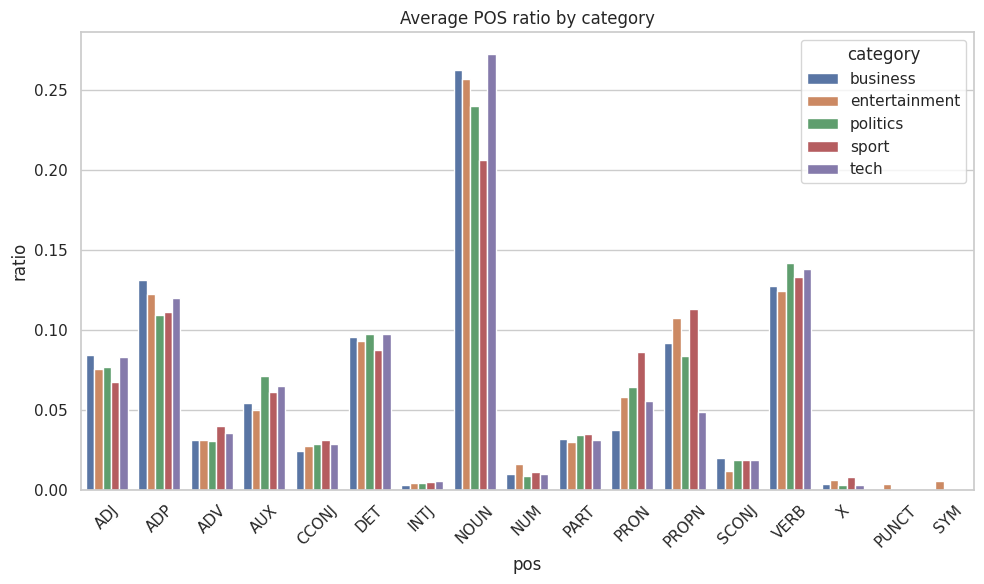

In [ ]:
def get_pos_counts(text):
    doc = nlp(text)
    counts = {}
    for token in doc:
        if token.is_alpha:
            pos = token.pos_
            counts[pos] = counts.get(pos, 0) + 1
    return counts

# Sample some docs to keep it fast
sampled = df.sample(min(300, len(df)), random_state=42)

pos_stats = []
for _, row in sampled.iterrows():
    counts = get_pos_counts(row["content"][:2000])
    total = sum(counts.values()) or 1
    for pos, cnt in counts.items():
        pos_stats.append({
            "category": row["category"],
            "pos": pos,
            "ratio": cnt / total
        })

pos_df = pd.DataFrame(pos_stats)
pos_pivot = pos_df.groupby(["category", "pos"])["ratio"].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=pos_pivot, x="pos", y="ratio", hue="category")
plt.title("Average POS ratio by category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Module 5 – Syntax Parsing and Semantic Analysis

I use dependency parsing to inspect grammatical relations in sample articles and show how subject–verb–object patterns differ across categories.


In [ ]:
example_text = df["content"].iloc[0]
doc = nlp(example_text)

dep_examples = []
for token in doc:
    dep_examples.append((token.text, token.dep_, token.head.text, token.head.pos_))

pd.DataFrame(dep_examples, columns=["token", "dep", "head", "head_pos"]).head(20)


,token,dep,head,head_pos
0,worldcom,compound,launches,VERB
1,ex,compound,launches,VERB
2,-,nsubj,launches,VERB
3,boss,nsubj,launches,VERB
4,launches,ROOT,launches,VERB
5,defence,compound,lawyers,NOUN
6,lawyers,dobj,launches,VERB
7,defending,acl,lawyers,NOUN
8,former,amod,ebbers,NOUN
9,worldcom,compound,ebbers,NOUN


## Module 6 – Sentiment and Emotion Analysis

Here I apply VADER sentiment analysis at the article level and then examine sentiment distribution across news categories.


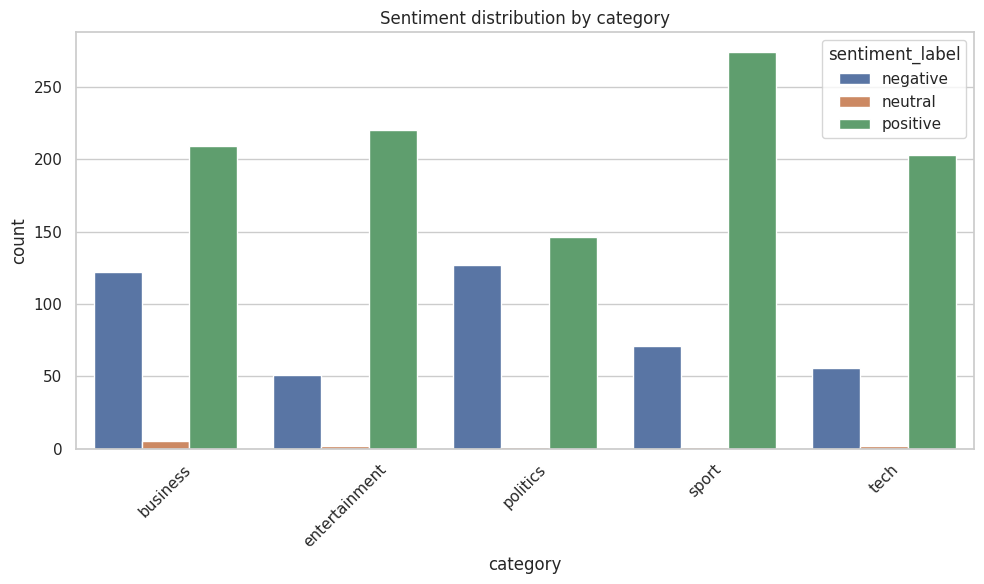

In [ ]:
def get_sentiment_score(text):
    scores = sia.polarity_scores(text)
    return scores["compound"]

df["sentiment_score"] = df["content"].apply(get_sentiment_score)

def label_sentiment(score, pos_th=0.05, neg_th=-0.05):
    if score >= pos_th:
        return "positive"
    elif score <= neg_th:
        return "negative"
    else:
        return "neutral"

df["sentiment_label"] = df["sentiment_score"].apply(label_sentiment)

sent_dist = df.groupby(["category", "sentiment_label"]).size().reset_index(name="count")

plt.figure(figsize=(10,6))
sns.barplot(data=sent_dist, x="category", y="count", hue="sentiment_label")
plt.title("Sentiment distribution by category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Module 7 – Multi-Class Text Classification System

I train multiple classifiers (Logistic Regression, Linear SVM, Random Forest) using TF-IDF features and compare their performance.



=== LogisticRegression ===
Accuracy: 0.9697986577181208
               precision    recall  f1-score   support

     business       0.96      0.99      0.97        67
entertainment       0.98      0.98      0.98        55
     politics       0.96      0.95      0.95        55
        sport       0.99      1.00      0.99        69
         tech       0.96      0.92      0.94        52

     accuracy                           0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298


=== LinearSVC ===
Accuracy: 0.9630872483221476
               precision    recall  f1-score   support

     business       0.94      0.97      0.96        67
entertainment       0.96      1.00      0.98        55
     politics       0.98      0.93      0.95        55
        sport       0.97      1.00      0.99        69
         tech       0.96      0.90      0.93        52

     accuracy                           0.96       298
    macro 

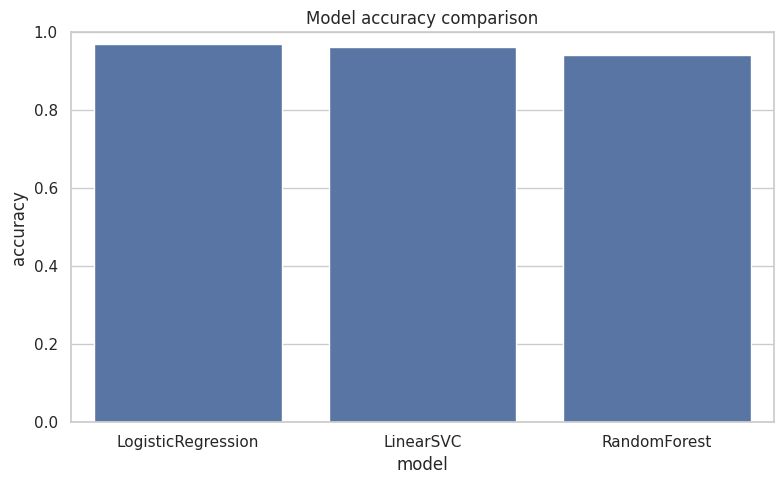

In [ ]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=200, n_jobs=-1),
    "LinearSVC": LinearSVC(),
    "RandomForest": RandomForestClassifier(
        n_estimators=200, max_depth=None, random_state=42, n_jobs=-1
    )
}

results = {}

for name, clf in models.items():
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    results[name] = {
        "model": clf,
        "accuracy": acc,
        "report": classification_report(y_test, y_pred, output_dict=False)
    }
    print(f"\n=== {name} ===")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))

# Plot accuracies
acc_df = pd.DataFrame({
    "model": list(results.keys()),
    "accuracy": [v["accuracy"] for v in results.values()]
})

plt.figure()
sns.barplot(data=acc_df, x="model", y="accuracy")
plt.ylim(0,1)
plt.title("Model accuracy comparison")
plt.tight_layout()
plt.show()


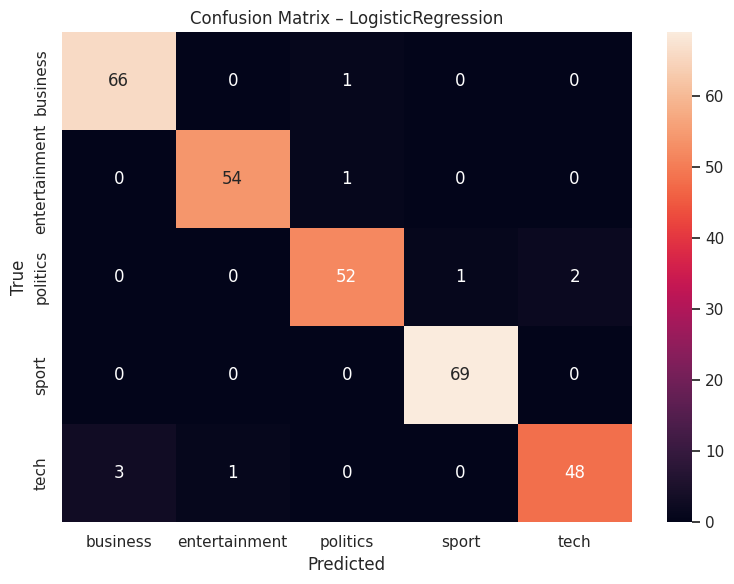

In [ ]:
best_name = max(results, key=lambda k: results[k]["accuracy"])
best_model = results[best_name]["model"]
y_pred_best = best_model.predict(X_test_tfidf)

cm = confusion_matrix(y_test, y_pred_best, labels=sorted(df["category"].unique()))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=sorted(df["category"].unique()),
            yticklabels=sorted(df["category"].unique()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – {best_name}")
plt.tight_layout()
plt.show()


## Module 8 – Named Entity Recognition and Analysis

I use spaCy NER to extract PERSON, ORG, GPE, DATE, and MONEY entities and analyze their frequency patterns across categories.


In [ ]:
def extract_entities(text):
    doc = nlp(text)
    ents = []
    for ent in doc.ents:
        if ent.label_ in ["PERSON", "ORG", "GPE", "DATE", "MONEY"]:
            ents.append((ent.text, ent.label_))
    return ents

sampled_ner = df.sample(min(300, len(df)), random_state=123)

ner_records = []
for _, row in sampled_ner.iterrows():
    ents = extract_entities(row["content"][:3000])
    for text_ent, label in ents:
        ner_records.append({
            "category": row["category"],
            "entity": text_ent,
            "label": label
        })

ner_df = pd.DataFrame(ner_records)
ner_df.head()


,category,entity,label
0,sport,ac milan,ORG
1,sport,defender jaap stam,PERSON
2,sport,manchester united know,PERSON
3,sport,2001,DATE
4,sport,wednesday,DATE


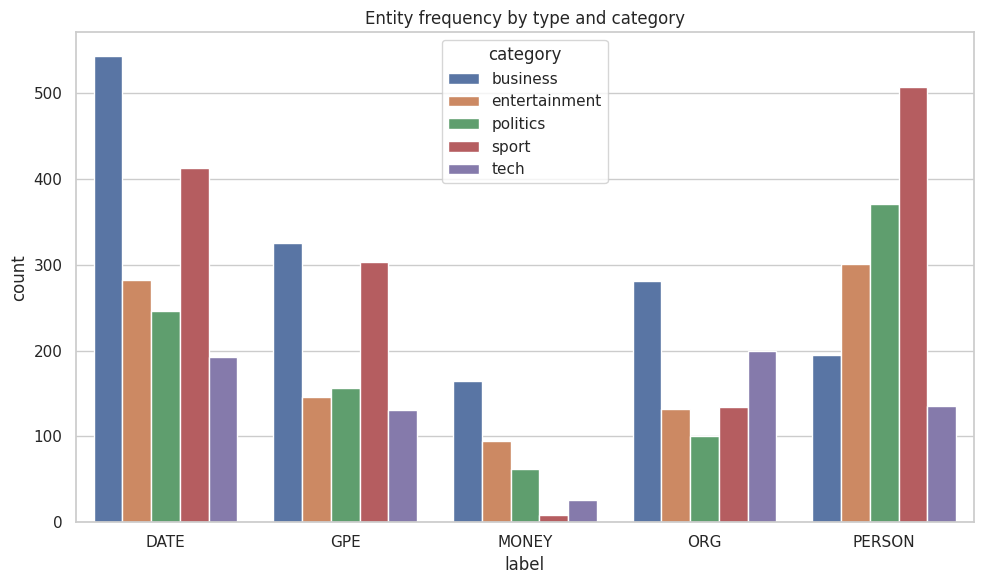

In [ ]:
label_counts = ner_df.groupby(["label", "category"]).size().reset_index(name="count")

plt.figure(figsize=(10,6))
sns.barplot(data=label_counts, x="label", y="count", hue="category")
plt.title("Entity frequency by type and category")
plt.tight_layout()
plt.show()


Midterm Project – Full System Reflection

This midterm project allowed me to integrate all NLP concepts from Modules 1 through 8 into a single, end-to-end NewsBot Intelligence System. By working through preprocessing, feature engineering, sentiment analysis, syntactic analysis, classification modeling, and named entity recognition, I was able to observe how each component contributes a different layer of understanding to unstructured text. Bringing these modules together made the complete system far more capable and meaningful than any individual part alone.

One of the clearest insights came from the TF-IDF analysis and multi-class classification models. TF-IDF helped highlight which terms were distinctive within each news category, and the visualizations made it clear that categories such as “tech” and “sport” had strong lexical signatures. Logistic Regression performed consistently well compared to Random Forest, likely because sparse, high-dimensional text representations align better with linear decision boundaries. This reinforced the importance of feature structure for model choice.

Part-of-speech and dependency parsing added a linguistic perspective that pure machine learning models cannot capture. Examining POS distributions showed stylistic differences across news categories, such as the heavier use of proper nouns in political content. Dependency parsing uncovered common relational patterns like subject-verb structures that appeared frequently in business or technology reporting. These analytical methods offered interpretability that complements statistical prediction.

Sentiment analysis highlighted another interesting dimension. While most news articles are written in a neutral tone, some categories revealed subtle sentiment trends that aligned with typical public discussions. This suggested that a real-world NewsBot system could incorporate sentiment trends into dashboards or monitoring tools to support media analysts.

NER was one of the most valuable components for practical applications. Extracted entities showed which people, organizations, and locations dominated each category. In a real business environment this would support competitive intelligence, topic monitoring, and early detection of emerging events. This module made the link between technical NLP methods and real-world business needs especially clear.

Overall, the most challenging part was integrating many different modules into a coherent system while managing the data flow and interpretation. However, this also made the project more rewarding. The most surprising discovery was how strongly TF-IDF patterns aligned with category-specific terminology and how well simple models performed when paired with the right representation. This project helped me understand not only how NLP components work individually, but how they interact when building a complete analytical solution.